# 

# TODO
- reinstall transformers with pytorch-nightly so that can use `mps` device

# Few to No Labels
Concepts Covered:
* Multi-label classification
* Baseline: Naive Bayes cast as a one-vs-rest problem (using `scikit-multilearn`)
* zero-shot classfication: recasting problem as a text entailment problem. 
    * top k vs threshold approach
* Text data augmentation (`nlpaug` library) 
* Using embeddings as a lookup table (FAISS)
    * how many neighbors? what threshold?
* Fine-Tuning a Vanilla Transformer
* Domain Adaptation: Fine-Tuning language model on unlabeled data before training model on labeled data.


**Original Application**: Github issue tagging  
**Potential Application at Nike**: NEoD conversation tagging

## Dataset Preparation


In [17]:
import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from skmultilearn.model_selection import iterative_stratification
import transformers as tfm

import fewlabels as fl

%load_ext autoreload
%autoreload 2

DATASET_URL = "https://git.io/nlp-with-transformers"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
df_issues = pd.read_json(DATASET_URL, lines=True)

print(f"Dataframe shape: {df_issues.shape}")

# only keep label name (drop id, nodes, ...)
df_issues["labels"] = df_issues.labels.apply(lambda l: [n['name'] for n in l])

# keep main labels and map to simpler lower case labels
LABEL_MAP = {
    "Core: Tokenization": "tokenization",
    "New model": "new model",
    "Core: Modeling": "model training",
    "Usage": "usage",
    "Core: Pipeline": "pipeline",
    "TensorFlow": "tensorflow",
    "PyTorch": "pytorch",
    "Examples": "examples",
    "Documentation": "documentation"
}

def filter_labels(labels: list[str]) -> list[str]:
    return [LABEL_MAP[label] for label in labels if label in LABEL_MAP]

df_issues["labels"] = df_issues.labels.apply(filter_labels)
all_labels = list(LABEL_MAP.values())

# adding a flag to know whether issue has at least one labeled or not
df_issues["labeled"] = df_issues.labels.apply(len) > 0


# drop duplicates
df_issues["text"] = df_issues.title + "\n\n" + df_issues.body
previous_length = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")

print(f"duplicates dropped: {previous_length - len(df_issues)}")

Dataframe shape: (9930, 26)
duplicates dropped: 187


/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)
/Users/spayot/miniforge3/envs/tfm9/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


False    9303
True      440
Name: labeled, dtype: int64

## Exploratory Data Analysis

In [22]:
# how many issues are labeled/unlabeled?
print(df_issues.labeled
    .map({True: "labeled", False: "unlabeled"})
    .value_counts()
    .to_string()
)

unlabeled    9303
labeled       440


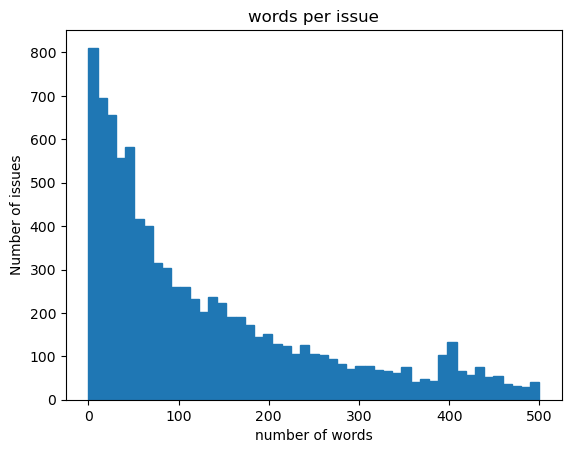

In [6]:
# word counts distribution per issue
(
    df_issues["text"].str.split()
    .apply(len)
    .hist(bins=np.linspace(0,500,50), grid=False, edgecolor="C0")
)
plt.title("words per issue")
plt.xlabel("number of words")
plt.ylabel("Number of issues")
plt.show()


### Labels distribution
Across labeled issues

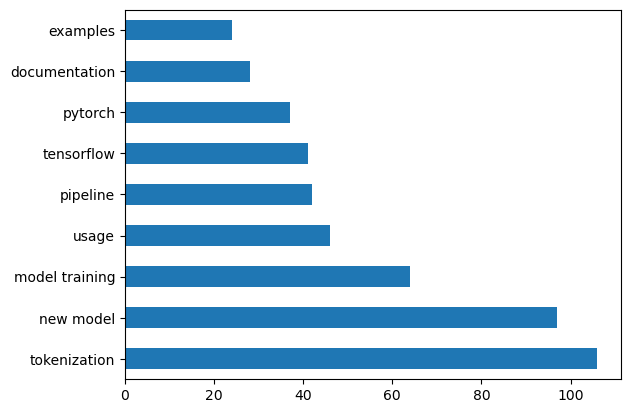

In [16]:

flattened_labels = df_issues.query("labeled == True").labels.sum()

_ = pd.Series(flattened_labels).value_counts().plot.barh()


# Creating a Training Set

In [23]:
# fit a label binarizer on data
mlb = sklearn.preprocessing.MultiLabelBinarizer()

mlb.fit([all_labels])
print(mlb.transform([["tokenization", "pytorch"], ["tensorflow"]]))


[[0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 1 0 0]]


In [30]:

def balanced_split(df: pd.DataFrame, test_size: float = 0.5) -> tuple[pd.DataFrame, pd.DataFrame]:
    """allows to create stratified data splits for multilabel datasets."""
    idx = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    idx_train, _, idx_test, _ = iterative_stratification.iterative_train_test_split(idx, labels, test_size=test_size)

    return df.iloc[idx_train[:,0]], df.iloc[idx_test[:,0]]

df_clean = df_issues[["text", "labels", "labeled"]].reset_index(drop=True).copy()

df_unsup = df_clean.loc[~df_clean.labeled, ["text","labels"]]
df_sup = df_clean.loc[df_clean.labeled, ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [32]:
ds = datasets.DatasetDict({
    "train": datasets.Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": datasets.Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": datasets.Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": datasets.Dataset.from_pandas(df_unsup.reset_index(drop=True)),
})

ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 9303
    })
})

### Creating Training Slices
Goal: test how efficient different strategies are depending on number of labeled samples

In [45]:
import fewlabels.preproc

In [47]:
# refactored
slice_sizes = [2**x for x in range(3,8)]
train_slices = fl.preproc.create_dataset_slices(ds["train"], slice_sizes, mlb=mlb, seed=0)

print(f"target split size: {slice_sizes}")
print(f"actual split size: {[len(s) for s in train_slices]}")

target split size: [8, 16, 32, 64, 128, 223]
actual split size: [10, 19, 36, 68, 134, 223]


In [43]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

100%|██████████| 10/10 [00:00<00:00, 196.56ba/s]


## Create Evaluator
The `SlicedTrainingEvaluator` fits a pipeline on training slices of various sizes and computes the f1-score (micro / macro) on the test set.

In [64]:
evaluator = fl.eval.SlicedTrainingEvaluator(ds=ds, train_slices=train_slices, mlb=mlb)

# Naive Bayes Baseline

In [65]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

strategy = "Naive Bayes"

pipe = Pipeline([
    ("vectorizer", CountVectorizer()), 
    ("clf", BinaryRelevance(classifier=MultinomialNB()))
    ])

evaluator.evaluate_pipe_on_slices(pipe, strategy=strategy)



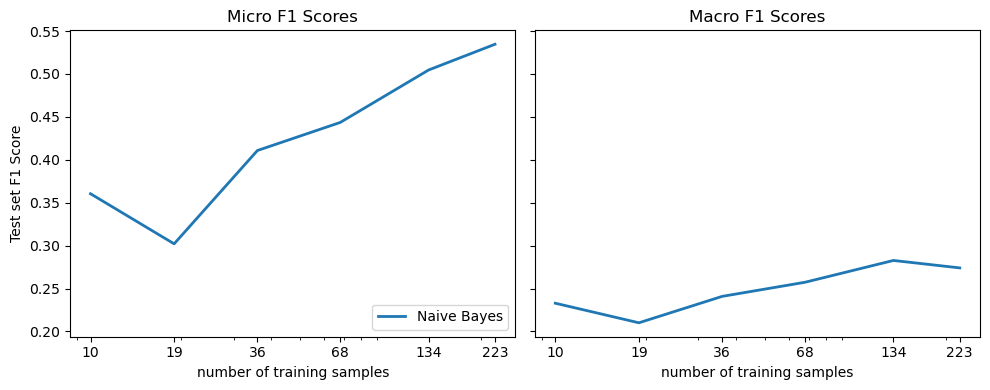

In [66]:
fl.plot.plot_metrics(evaluator, "Naive Bayes")

## Working with No Labeled Data: Zero-Shot Classification
* turn task into an entailment task to figure out whether topics are related by comparing text to a sentence of the form: `"this section was about the topic [MASK]"`